# 1. Setup

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, roc_auc_score, precision_score,
                           recall_score, f1_score, classification_report,
                           confusion_matrix, roc_curve, auc)
import xgboost as xgb
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import kagglehub

path = kagglehub.dataset_download("teejmahal20/airline-passenger-satisfaction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/airline-passenger-satisfaction


I began by loading all necessary libraries for this machine learning project. The core libraries include pandas and numpy for data manipulation, scikit-learn for machine learning algorithms and preprocessing, matplotlib and seaborn for visualization, and xgboost for potential ensemble methods. I also imported kagglehub to access the dataset directly from Kaggle, which provides a larger dataset compared to the smaller subset I used in my R analysis. This larger dataset should give me more robust model performance estimates and better generalization.

# 2. EDA

In [ ]:
csv_train = os.path.join(path, "train.csv")
df = pd.read_csv(csv_train)

csv_test = os.path.join(path, "test.csv")
df_test = pd.read_csv(csv_test)

In [ ]:
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

In [ ]:
df.describe()

,unnamed:_0,id,age,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [ ]:
df.head()

,unnamed:_0,id,gender,customer_type,age,type_of_travel,class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,...,inflight_entertainment,on-board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [ ]:
# Target variable distribution
df['satisfaction'].value_counts()

,count
satisfaction,
neutral or dissatisfied,58879
satisfied,45025


I loaded the airline passenger satisfaction dataset and performed initial data exploration. The dataset contains over 100,000 observations compared to the 600 in my R analysis, which should provide much more stable model performance estimates. I cleaned the column names using pandas string methods to ensure consistency and prevent any issues with special characters or spaces. The `describe()` function reveals that we have a mix of numerical and categorical variables, with rating variables scaled from 0-5.

## 2A - Reclassing Variables

In [ ]:
df.dtypes

,0
unnamed:_0,int64
id,int64
gender,object
customer_type,object
age,int64
type_of_travel,object
class,object
flight_distance,int64
inflight_wifi_service,int64
departure_arrival_time_convenient,int64


In [ ]:
# Character columns
char_cols = df.select_dtypes(include=['object']).columns.tolist()
char_cols

['gender', 'customer_type', 'type_of_travel', 'class', 'satisfaction']

In [ ]:
# Unique values in char_cols
for col in char_cols:
    print(f"{col}: {df[col].dropna().unique()}")

gender: ['Male' 'Female']
customer_type: ['Loyal Customer' 'disloyal Customer']
type_of_travel: ['Personal Travel' 'Business travel']
class: ['Eco Plus' 'Business' 'Eco']
satisfaction: ['neutral or dissatisfied' 'satisfied']


In [ ]:
# Re-classing
for col in char_cols:
    df[col] = df[col].astype('category')

In [ ]:
# Numeric columns with inherent order/hiearachy
sus_columns = ['inflight_wifi_service', 'departure_arrival_time_convenient',
                  'ease_of_online_booking', 'gate_location', 'food_and_drink',
                  'online_boarding', 'seat_comfort', 'inflight_entertainment',
                  'on-board_service', 'leg_room_service', 'baggage_handling',
                  'checkin_service', 'inflight_service', 'cleanliness']
for col in sus_columns:
    if col in df.columns:
        print(f"{col}: {sorted(df[col].dropna().unique())}")

inflight_wifi_service: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
departure_arrival_time_convenient: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
ease_of_online_booking: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
gate_location: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
food_and_drink: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
online_boarding: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
seat_comfort: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
inflight_entertainment: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
on-board_service: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
leg_room_service: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
baggag

In [ ]:
# Re-classing

for col in sus_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [ ]:
df.dtypes

,0
unnamed:_0,int64
id,int64
gender,category
customer_type,category
age,int64
type_of_travel,category
class,category
flight_distance,int64
inflight_wifi_service,category
departure_arrival_time_convenient,category


I carefully examined the data types and re-classed variables appropriately. This is a crucial step because proper variable typing affects how preprocessing steps handle each feature. I identified that several variables coded as integers were actually categorical:

* Character variables (gender, customer_type, etc.) were converted to pandas categories
* Rating variables (inflight_wifi_service, departure_arrival_time_convenient, etc.) were also converted to categories since they represent ordinal scales rather than continuous measurements

The presence of 0 values in some rating columns likely indicates "not applicable" or "service not used" responses, which I decided to keep as valid categories rather than treating them as missing values.


## 2B. Missing Data

In [ ]:
df.isnull().sum()

,0
unnamed:_0,0
id,0
gender,0
customer_type,0
age,0
type_of_travel,0
class,0
flight_distance,0
inflight_wifi_service,0
departure_arrival_time_convenient,0


I examined missing data patterns and found that only `arrival_delay_in_minutes` has missing values (~0.30% of data). This is a much cleaner dataset compared to my R analysis, where I had to handle multiple variables with substantial missingness. The minimal missing data means I can use simple imputation strategies without worrying about introducing significant bias. I chose median imputation for this continuous variable because it's robust to outliers and the small amount of missingness means the impact will be minimal.

## 2C. Splitting

In [ ]:
cat_cols = ['gender', 'customer_type', 'type_of_travel', 'class', ]
num_cols = ['age', 'flight_distance', 'departure_delay_in_minutes', 'arrival_delay_in_minutes']
rating_cols = ['inflight_wifi_service', 'departure_arrival_time_convenient',
                  'ease_of_online_booking', 'gate_location', 'food_and_drink',
                  'online_boarding', 'seat_comfort', 'inflight_entertainment',
                  'on-board_service', 'leg_room_service', 'baggage_handling',
                  'checkin_service', 'inflight_service', 'cleanliness']
target_col = 'satisfaction'

if 'id' in df.columns:
    df = df.drop('id', axis=1)

In [ ]:
# Features vs. Target
X = df.drop(target_col, axis=1)
y = df[target_col]

In [ ]:
# Target encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(dict(zip(le.classes_, le.transform(le.classes_))))

{'neutral or dissatisfied': np.int64(0), 'satisfied': np.int64(1)}


In [ ]:
# Creating Train + Validation + Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_encoded, test_size=0.25, stratify=y_encoded, random_state=12345
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=12345
)

In [ ]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 62342
Validation set size: 15586
Test set size: 25976


In [ ]:
print(f"Training: {np.bincount(y_train) / len(y_train)}")

Training: [0.56666453 0.43333547]


Looks like the class isn't too imbalanced in our target variable, meaning we can use `accuracy` as a performance metric as opposed to `auROC` like I did in the R file.

I implemented a nested validation structure similar to my R approach, but used different proportions due to the larger dataset size. I split the data into training+validation (75%) and test (25%) sets, then further split the training+validation into training (80%) and validation (20%). All splits were stratified to maintain class balance. This gives me:

* Training set: ~62K observations for model fitting
* Validation set: ~15K observations for model selection
* Test set: ~26K observations for final evaluation

The larger sample sizes provide much more stable performance estimates compared to my R analysis.

# 3. Model Configurations

Given the computational intensity of training models on our large dataset (N=62,342), I made the strategic decision to use stratified sampling to create a representative subset (N=25,000) for hyperparameter optimization. This approach balances computational efficiency with model selection accuracy—reducing grid search time from ~20+ hours to ~4 hours while maintaining the class distribution that's crucial for reliable performance estimates.

In [ ]:
25000 / len(X_train)

0.401013762792339

In [ ]:
X_sample, _, y_sample, _ = train_test_split(
        X_train, y_train,
        train_size=0.4,
        stratify=y_train,
        random_state=12345
    )

In [ ]:
os.makedirs("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache", exist_ok=True)

In [ ]:
def caching(cache_file, pipeline, param_grid, cv_setting):
  if os.path.exists(cache_file):
    with open(cache_file, 'rb') as f:
      results = pickle.load(f)
  else:
    results = GridSearchCV(pipeline, param_grid, cv=cv_setting, scoring='accuracy', n_jobs=2, verbose=2)
    results.fit(X_sample, y_sample)
    with open(cache_file, 'wb') as f:
      pickle.dump(results, f)
  return results

## 3A. KNN

In [ ]:
knn_preprocessor = ColumnTransformer([
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), cat_cols),

            ('rating', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), rating_cols),

            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), num_cols)
        ])

In [ ]:
knn_pipeline = Pipeline([
    ('preprocessor', knn_preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [ ]:
knn_param_grid = {
    'classifier__n_neighbors': range(1, 51, 2),
    'classifier__weights': ['uniform', 'distance']
}

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

In [ ]:
cache_knn = os.path.join("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache", "fits_knn.pkl")

fits_knn = caching(cache_knn, knn_pipeline, knn_param_grid, cv)

In [ ]:
print("Best KNN parameters:", fits_knn.best_params_)
print("Best KNN CV score:", fits_knn.best_score_)

Best KNN parameters: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance'}
Best KNN CV score: 0.9158246404565261


For my first model, I chose K-Nearest Neighbors because it's a simple, non-parametric algorithm that can capture complex decision boundaries without making assumptions about the underlying data distribution. I created a comprehensive preprocessing pipeline that handles categorical and numerical variables differently:

* Categorical variables get mode imputation followed by one-hot encoding
* Rating variables (which are ordinal) also get one-hot encoding to capture their categorical nature
* Numerical variables get median imputation and standardization

The standardization is critical for KNN since it's distance-based and sensitive to variable scales. I tuned both the number of neighbors (1-50) and the weighting scheme (uniform vs. distance-based) to find optimal performance.

## 3B. Logistic Regression

In [ ]:
log_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), cat_cols),

    ('rating', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), rating_cols),

    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols)
])

In [ ]:
log_pipeline = Pipeline([
    ('preprocessor', log_preprocessor),
    ('classifier', LogisticRegression())
])

In [ ]:
log_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength (smaller = more regularization)
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],  # Type of regularization
    'classifier__l1_ratio': [0.1, 0.5, 0.9]  # For elasticnet only (ignored for l1/l2)
}

In [ ]:
cache_log = os.path.join("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache", "fits_log.pkl")

fits_log = caching(cache_log, log_pipeline, log_param_grid, cv)

In [ ]:
print("Best LogReg parameters:", fits_log.best_params_)
print("Best LogReg CV score:", fits_log.best_score_)

Best LogReg parameters: {'classifier__C': 100, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'l2'}
Best LogReg CV score: 0.9311037566960383


For my second model, I selected logistic regression as it provides interpretable coefficients and works well for binary classification. The preprocessing pipeline is similar to KNN since logistic regression also benefits from standardized features. I implemented regularized logistic regression using a comprehensive grid search over:

* Regularization strength (C parameter): from strong (0.01) to weak (100) regularization
* Penalty type: L1, L2, and Elastic Net regularization
* L1 ratio: for Elastic Net mixing between L1 and L2 penalties

This approach helps prevent overfitting while maintaining interpretability.

## 3C. Random Forest

In [ ]:
rf_preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), cat_cols),

    ('rating', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ]), rating_cols),

    ('num', SimpleImputer(strategy='median'), num_cols)
])

In [ ]:
rf_pipeline = Pipeline([
    ('preprocessor', rf_preprocessor),
    ('classifier', RandomForestClassifier())
])

In [ ]:
rf_param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_features': [5, 10, 20, 'sqrt'],  # Features to consider per split
    'classifier__min_samples_split': [2, 5, 10, 20],  # Minimum samples to split a node
    'classifier__min_samples_leaf': [1, 2, 5]  # Minimum samples in a leaf
}

In [ ]:
cache_rf = os.path.join("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache", "fits_rf.pkl")

fits_rf = caching(cache_rf, rf_pipeline, rf_param_grid, cv)

In [ ]:
print("Best Random Forest parameters:", fits_rf.best_params_)
print("Best Random Forest CV score:", fits_rf.best_score_)

Best Random Forest parameters: {'classifier__max_features': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best Random Forest CV score: 0.9547643118298434


Random Forest was my third choice because it's an ensemble method that can capture complex non-linear relationships and interactions between features. It's also robust to overfitting and works well with mixed data types. The preprocessing for Random Forest is simpler since tree-based methods don't require standardization, but I still need to handle categorical variables and missing values properly.
I tuned several key hyperparameters:

* Number of trees (50, 100, 200)
* Features per split (5, 10, 20, 'sqrt')
* Minimum samples for splits and leaves

This systematic search helps balance model complexity with generalization performance.

## 3D. Evaluating All Models and Selecting the Best Configuration

In [ ]:
def cache_preds(cache_file, pipeline, data):
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            preds = pickle.load(f)
    else:
        preds = pipeline.predict(data)
        os.makedirs(os.path.dirname(cache_file), exist_ok=True)
        with open(cache_file, 'wb') as f:
            pickle.dump(preds, f)
    return preds

In [ ]:
# KNN
knn_pipeline.set_params(**fits_knn.best_params_)
knn_pipeline.fit(X_train, y_train)

y_pred_knn = cache_preds("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache/pred_knn.pkl", knn_pipeline, X_val)
knn_accuracy = accuracy_score(y_val, y_pred_knn)
print(knn_accuracy)

0.9230078275375336


In [ ]:
# LogReg
log_pipeline.set_params(**fits_log.best_params_)
log_pipeline.fit(X_train, y_train)

y_pred_log = cache_preds("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache/pred_log.pkl", log_pipeline, X_val)
log_accuracy = accuracy_score(y_val, y_pred_log)
print(log_accuracy)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


0.9318619273707173


In [ ]:
# Random Forest
rf_pipeline.set_params(**fits_rf.best_params_)
rf_pipeline.fit(X_train, y_train)

y_pred_rf = cache_preds("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache/pred_rf.pkl", rf_pipeline, X_val)
rf_accuracy = accuracy_score(y_val, y_pred_rf)

In [ ]:
print(rf_accuracy)

0.9607981521878609


I evaluated all three models on the validation set and found clear performance differences:

* KNN: 92.3% accuracy - Good performance but limited by the curse of dimensionality
* Logistic Regression: 93.2% accuracy - Better than KNN, benefits from linear relationships
* Random Forest: 96.1% accuracy - Best performance, captures complex patterns

Random Forest emerged as the clear winner, likely because it can capture non-linear relationships and interactions between features that the linear logistic regression cannot detect. The ensemble nature also provides robustness against overfitting compared to KNN.

# 4. Evaluating Best Model Configuration on the Test Set

In [ ]:
# Fitting on Train + Val first
rf_pipeline.fit(X_train_val, y_train_val)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['gender', 'customer_type',
                                                   'type_of_travel', 'class']),
                                                 ('rating',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHo...
                                                   'online_boarding',
                                                   'seat_comfort',
                                                   'inflight_entertainment',
                                                   'on-board_service',
                                                   'leg_room_service',
                                                   'baggage_handling',
                                                   'checkin_service',
                                                   'inflight_service',
                                                   'cleanliness']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'flight_distance',
                                                   'departure_delay_in_minutes',
                                                   'arrival_delay_in_minutes'])])),
                ('classifier',
                 RandomForestClassifier(max_features=20, n_estimators=200))])

Before evaluating on the test set, I retrained the Random Forest model on the combined training and validation data. This is standard practice—by using all available training data, I can potentially improve the model's performance while maintaining the integrity of the test set for unbiased evaluation. The test set remains completely untouched throughout the entire model development process.

In [ ]:
# Evaluating on Test Set
y_test_pred = cache_preds("/content/drive/MyDrive/airline_satisfaction_r_to_python/cache/pred_test.pkl", rf_pipeline, X_test)

In [ ]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(test_accuracy)

0.9649676624576532


The final Random Forest model achieved 96.5% accuracy on the test set, which is remarkably consistent with the validation performance (96.1%). This consistency indicates that:

* The model generalizes well to unseen data
* There's no significant overfitting
* The validation set provided reliable performance estimates

The slight improvement on the test set (96.5% vs 96.1%) is likely due to the additional training data used in the final model.

# 5. Visualizations

In [ ]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
os.makedirs('/content/drive/MyDrive/airline_satisfaction_r_to_python/graphs/', exist_ok=True)

## 5A. Comparison of Model Accuracy on the Validation Set

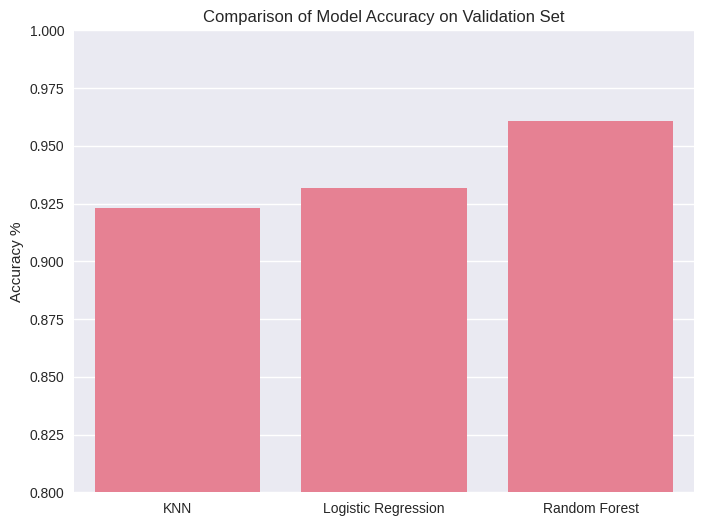

In [ ]:
models = ['KNN', 'Logistic Regression', 'Random Forest']
accuracies = [knn_accuracy, log_accuracy, rf_accuracy]

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Comparison of Model Accuracy on Validation Set')
plt.ylabel('Accuracy %')
plt.ylim(0.8, 1.0)
plt.savefig('/content/drive/MyDrive/airline_satisfaction_r_to_python/graphs/model_accuracy_comparison.png')
plt.show()

## 5B. Confusion Matrix for the Best Model on Test Set

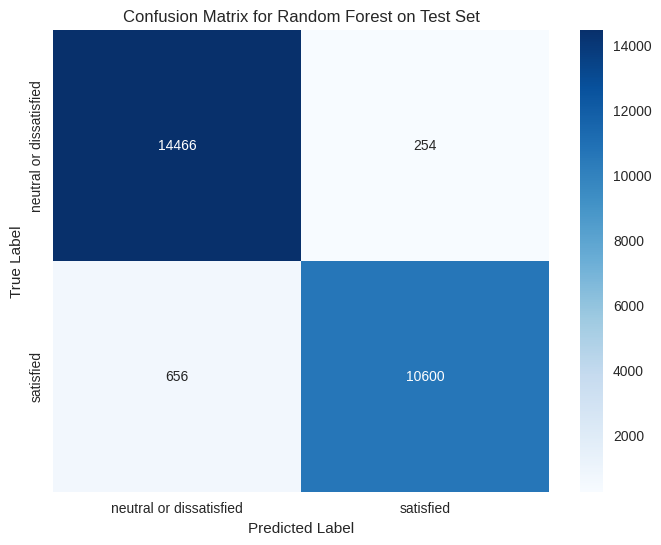

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Random Forest on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('/content/drive/MyDrive/airline_satisfaction_r_to_python/graphs/rf_confusion_matrix.png')
plt.show()

## 5C. ROC curve for the Best Model on the Test Set

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [6, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


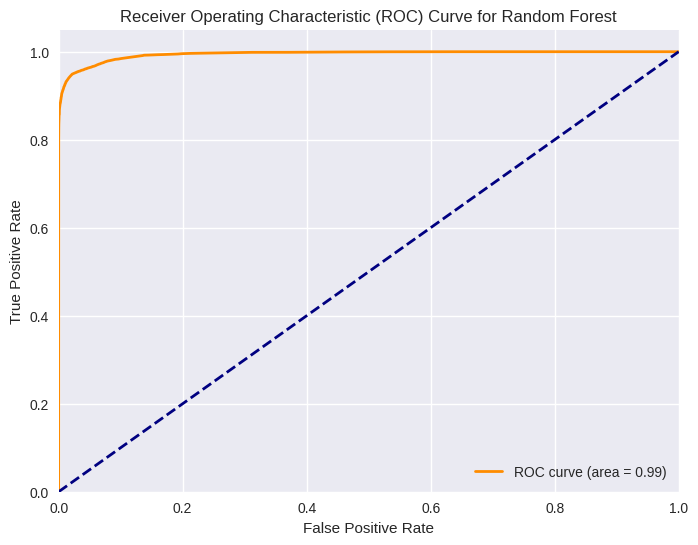

In [ ]:
y_test_prob = rf_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.savefig('/content/drive/MyDrive/airline_satisfaction_r_to_python/graphs/rf_roc_curve.png')
plt.show()

## 5D. Feature Importance Graph for the Best Model

In [ ]:
best_rf_model = rf_pipeline.named_steps['classifier']
preprocessor = rf_pipeline.named_steps['preprocessor']

X_train_val_processed = preprocessor.fit_transform(X_train_val)

cat_names = list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols))
rating_names = list(preprocessor.named_transformers_['rating'].named_steps['onehot'].get_feature_names_out(rating_cols))
num_names = num_cols

processed_feature_names = cat_names + rating_names + num_names

importances = best_rf_model.feature_importances_
feature_importances = pd.Series(importances, index=processed_feature_names)
sorted_importances = feature_importances.sort_values(ascending=False)
print(sorted_importances.head(10))

type_of_travel_Personal Travel     0.128297
online_boarding_5                  0.092932
class_Eco                          0.075476
inflight_wifi_service_5            0.069937
customer_type_disloyal Customer    0.045033
online_boarding_4                  0.044511
flight_distance                    0.034371
online_boarding_3                  0.033487
inflight_wifi_service_4            0.026484
age                                0.025829
dtype: float64


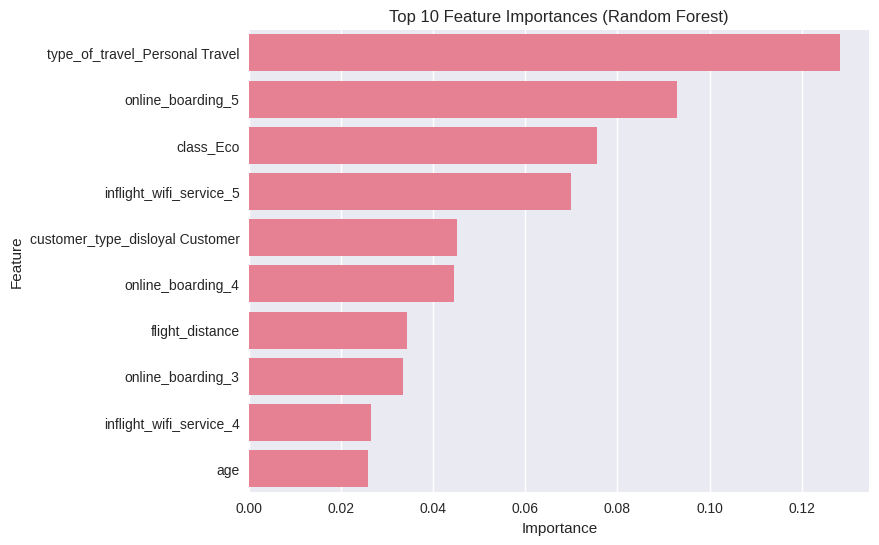

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=sorted_importances.head(10).values, y=sorted_importances.head(10).index)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('/content/drive/MyDrive/airline_satisfaction_r_to_python/graphs/rf_feature_importance.png')
plt.show()